# Исследование заведений общественного питания г. Москва

## Общие положения

**Дата выполнения проекта:** 20 июня 2021.

**Адресат исследования** — инвестор.

**Цель исследования** — оценить потенциал нового оригинального кафе с роботами-официантами.

**Задачи исследования:**

1. Исследовать рынок заведений общественного питания;
2. Определить факторы, способствующие успеху заведения.

**Этапы исследования:**

- <a href='#Изучение-и-предобработка-данных'>изучение и предобработка данных</a>;
- <a href="#Анализ-данных">обогащение и исследовательский анализ данных</a>;
- <a href="#Общий-вывод">общий вывод</a>;
- <a href="#Презентация">подготовка презентации для инвесторов</a>.

**Столбцы данных:**
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

## <a>Изучение и предобработка данных</a>

In [1]:
# обновление библиотек
#!pip install -U plotly
#!pip install -U stats
!pip install -U seaborn
!pip install -U pandas

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /home/jovyan/.local/lib/python3.7/site-packages (1.2.4)


In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
import re
import math as mt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from datetime import date
from scipy import stats as st

In [4]:
# зададим количество отображаемых столбцов, чтобы видеть все
pd.options.display.max_columns = 200

In [5]:
# прочитаем файл локально или с сервера
try: 
    data = pd.read_csv('rest_data.csv')
except:
    data = pd.read_csv('/datasets/rest_data.csv')

# изучим информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Предоставленный файл содержит 15366 записей, что представляется достаточным для анализа объемом. В колонках нет пустых значений. Перейдем к визуальному изучению файла.

In [6]:
# методом .head() выведем первые 5 строчек датасета
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Столбцы с id и количеством посадочных мест имеют верный тип значений int, остальные колонки содержат текстовые данные, так что формат подходящий. Изучим значения в колонке number.

In [7]:
# приведем написание названий к нижнему регистру
data['object_name'] = [c.lower() for c in data['object_name']]
data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [8]:
data['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Минимальное количество посадочных мест — 0. Вероятно, это предприятия, которые работают на вынос. Посмотрим, у каких типов заведений количество посадочных мест равно нулю.

In [9]:
print(data.query('number == 0').groupby('object_type')['id'].count())
print()
print('Доля нулей: {:.2%}'.format(len(data.query('number == 0'))/ len(data)))

object_type
бар                                   28
буфет                                 68
закусочная                           189
кафе                                 310
кафетерий                            113
магазин (отдел кулинарии)            145
предприятие быстрого обслуживания    704
ресторан                              45
столовая                              19
Name: id, dtype: int64

Доля нулей: 10.55%


Как мы и предполагали, большинство заведений без посадочных мест относятся к предприятиям быстрого обслуживания. Кафе и рестораны с нулем посадочных мест выглядят подозрительно. Вероятно, данные не были предоставлены. Нули составляют значительную долю датасета — 10,5%, показатель не влияет на изучение популярности заведений по видам, поэтому удалять их не будем. Для анализа распределения заведений по количеству мест исключим нулевые и сверхбольшие значения. Изучим, есть ли в данных дубликаты.

In [10]:
# отберем из датасета нужные столбцы
data_duplicats_check = data.loc[:, 'object_name':'number']
# посчитаем количество дублей
duplicates = data_duplicats_check.duplicated().sum()

# для расчета доли дублей найдем длину массива через функцию len()
duplicates_part = duplicates / len(data_duplicats_check)

print('Количество дублирующихся строк в данных:', duplicates)
print('Доля дублей в данных: {:.2%}'.format(duplicates_part))

Количество дублирующихся строк в данных: 85
Доля дублей в данных: 0.55%


In [11]:
data_no_id = data_duplicats_check.drop_duplicates()
data_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15281 entries, 0 to 15365
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  15281 non-null  object
 1   chain        15281 non-null  object
 2   object_type  15281 non-null  object
 3   address      15281 non-null  object
 4   number       15281 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 716.3+ KB


Посмотрим, какие варианты значений есть в столбце object_type: список должен содержать ограниченное количество значений, не повторяющихся по смыслу.

In [12]:
# посчитаем количество объектов по типам
data_no_id.groupby('object_type').agg({'object_name': 'count'}).reset_index()

,object_type,object_name
0,бар,855
1,буфет,576
2,закусочная,348
3,кафе,6071
4,кафетерий,395
5,магазин (отдел кулинарии),273
6,предприятие быстрого обслуживания,1897
7,ресторан,2282
8,столовая,2584


**Вывод по разделу "Изучение данных":** в данных нет пропусков, тип значений в каждой колонке соответствует содержанию. Был небольшой процент дублей (0,55%), которые могли появится в случае сбора данных из разных источников. Дублирующиеся данные удалены, поскольку могу завысить показатели по конкретному типу заведений.
В столбце object_type используются однотипные, непротиворечивые значения, замен не требуется. В столбце number (количество посадочных мест) встречаются нули в типах заведений, которые посадочные места предполагают. Поскольку сбор данных происходил из открытых источников, то либо данные в органы статистики не предоставлены, либо имели место ошибки парсинга. При повторном проведении анализа стоит уточнить причину проблемы и по возможности устранить. Текущие данные готовы к анализу.

## <a>Анализ данных</a>

### Распространенность и вместимость заведений в зависимости от типа

Изучим, как заведения распределяются по типам, есть ли разница между сетевым и несетевым общепитом, какого среднее количество мест в заведениях.

In [13]:
# заменим названия типов "магазин (отдел кулинарии)" и "предприятие быстрого обслуживания" на более короткие
data_replaced = data_no_id.replace({'магазин (отдел кулинарии)': 'кулинария', 'предприятие быстрого обслуживания':'фастфуд'})

In [14]:
# объявим функцию для построения графиков
def bar_maker(data, title, x, y):
    with plt.style.context('ggplot'):
        data.plot(kind = 'bar', title = title, xlabel = x, ylabel = y, figsize=(9, 5))

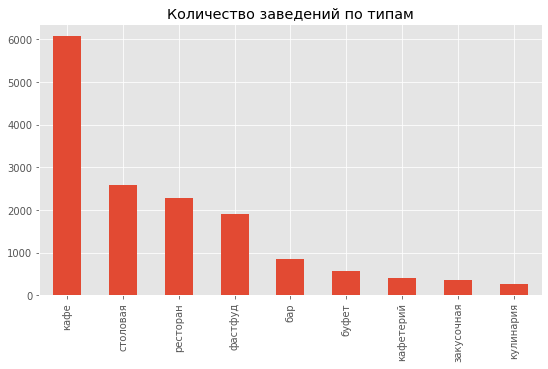

In [15]:
# построим график
bar_maker(data_replaced.groupby('object_type')['object_type'].count().sort_values(ascending=False),\
          'Количество заведений по типам', '', '')

ТОП-3 заведений по типу:
- кафе — более 6000 точек;
- столовые — около 2500 заведений;
- рестораны — примерно 2300 точек.

In [16]:
# найдем долю сетевых заведений в каждом формате
data_chain = data_replaced.pivot_table(index = 'object_type', columns = 'chain', values = 'object_name', aggfunc = 'count')
data_chain['total'] = data_chain['да'] + data_chain['нет']
data_chain['part'] = data_chain.apply(lambda x: (x['да'] / x['total'] * 100), axis=1)

# отберем данные для графика
data_chain_bar = data_chain.loc[:, 'part']

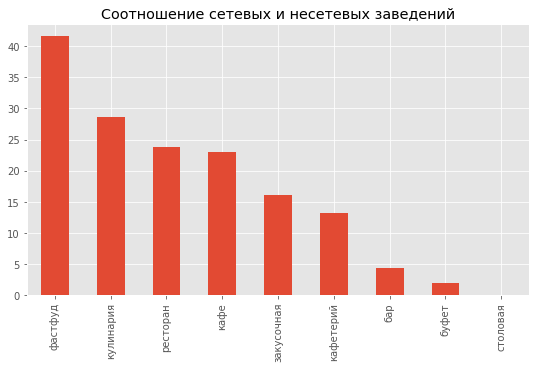

In [17]:
# воспользуемся ранее объявленной функцией
bar_maker(data_chain_bar.sort_values(ascending=False),\
          'Соотношение сетевых и несетевых заведений', '', '')

Cреди сетевых заведений наибольшую долю имеет фастфуд (более 40% заведений из категории), вторые по популярности кулинарии (около 28%), почти равные доли у ресторанов и кафе (примерно 23-24%). Вероятно, лидерство фастфуда объясняется наличием международных игроков, которые давно развивают бизнес через франчайзинг. Посмотрим, как связано количество заведений сети и количество посадочных мест.

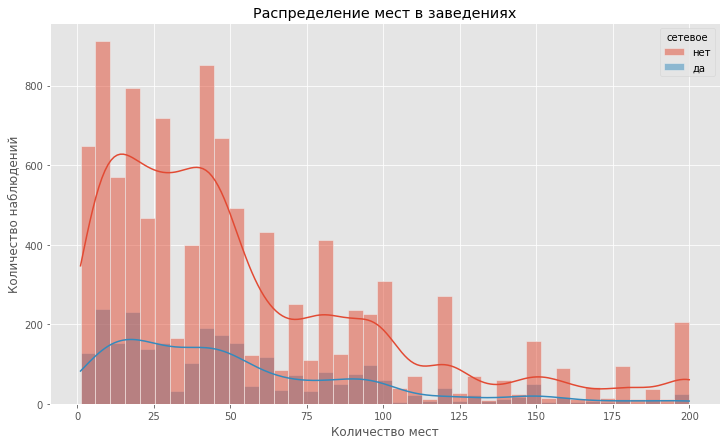

In [18]:
# подготовим датасет: оставим заведения с количеством мест не более 200
data_distribution = data_replaced.query('number > 0 and number <= 200').rename(columns={'chain':'сетевое'})

# построим график распределения по сетевым и несетевым заведениям
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.histplot(data=data_distribution[['object_name', 'number', 'сетевое']], x = 'number', kde=True, hue='сетевое')
    ax.set_title('Распределение мест в заведениях')
    ax.set_xlabel('Количество мест')
    ax.set_ylabel('Количество наблюдений')
    plt.show

Распределения мест по количеству в сетевой и несетевой рознице имеют похожий характер, хотя сетевое распределение менее выраженное, имеет значительно менее выраженные колебания. Посмотрим на распределение мест в сетевой рознице.

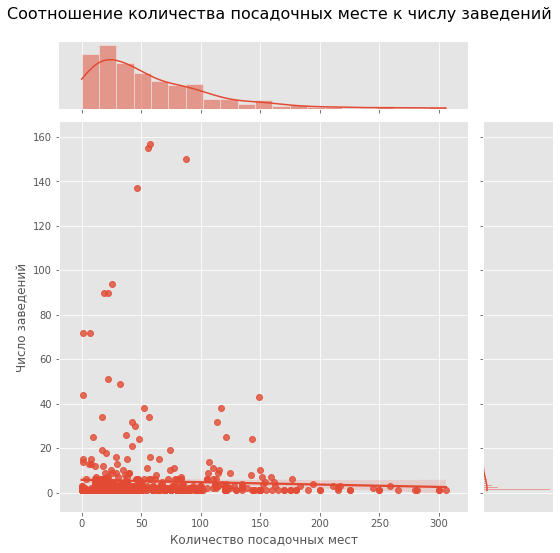

In [19]:
# подготовим датасет, отберем только сетевые заведения
data_scatter = data_replaced.query('chain == "да"').groupby('object_name')\
                            .agg({'object_name':'count', 'number':'mean'})

# построим график
with plt.style.context('ggplot'):
    s = sns.jointplot(x='number', y='object_name', data=data_scatter, kind='reg')
    s.fig.set_figwidth(8)
    s.fig.set_figheight(8)
    s.fig.suptitle('Соотношение количества посадочных месте к числу заведений', fontsize=16)
    s.fig.subplots_adjust(top = 0.92)
    s.set_axis_labels('Количество посадочных мест', 'Число заведений')

Чаще всего, в состав сетей входит небольшое количество заведений (до 20) с небольшим количество посадочных мест (до 50). Надо отметить, что в анализируемом датасете большую часть составляют сети с одним заведением и широким разбросом вместимости (до 300 мест), но также встречаются и крупные сети (до 160 заведений) с 60-70 местами (вероятно, как раз в эту категорию попадают заведения фастфуда).

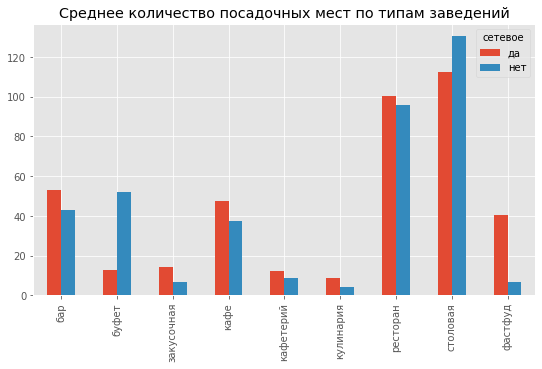

In [20]:
# воспользуемся ранее написанной функцией
bar_maker(data_replaced.rename(columns={'chain':'сетевое'})\
          .pivot_table(index='object_type', columns = 'сетевое', values='number', aggfunc='mean'),\
          'Среднее количество посадочных мест по типам заведений', '', '')

Закономерным является факт, что наибольшее количество посадочных мест в столовых (более 100). Следующие по вместимости рестораны (сетевые и несетевые) практически — 100 мест. Третье место у баров — около 50.
Наиболее сильные разброс в количестве посадочных мест между сетевой и несетевой розницей в буфетах и фастфуде: сетевой фастфуд обычно большой (40 посадочных мест), тогда как в несетевом менее 5 мест в среднем. Вероятно, несетевой фастфуд вообще работает на вынос. А вот с буфетами ситуация обратная — сетевые заведения компактные (около 10 мест), а несетевые сопоставимы с барами (50 мест).

### Географическая представленность заведений

#### Обогащение данных: выделение улиц, добавление данных о районе

Для дальнейшего анализа выделим из адреса улицу и добавим данные о районе из внешнего источника.

In [21]:
# объявим функцию, которая будет выделять название улицы/проспекта/переулка и так далее,
# вне зависимости от взаимного расположения типа и названия
# закомментирована обработка населенных пунктов второго уровня и вывод необработанных значений
def street(address): 
    types = ['улица', 'переулок', 'шоссе', 'проезд', 'проспект', 'набережная', 'бульвар', 'площадь', 
             'аллея', 'тупик', 'микрорайон', 'квартал[^,]*', 'линия[^,]*', 'территория',  
#             'поселение [^,]*, (село|посёлок|деревня|рабочий посёлок)[^,]*', 'километр', 
#             'просек', 'вблизи', '(рабочий )*посёлок' 
            ] 
    m = re.search(f"({'|'.join([f'{t} ([^,]+)|([^,]+) {t}' for t in types])})", address) 
    if m is not None: 
        return m.group(1).strip() 
    else: 
#        print(address) 
        return ''

# объявим функцию, которая форматирует название улицы: выносит название типа вперед
def proper_street(street):
    types = ['улица', 'переулок', 'шоссе', 'проезд', 'проспект', 'набережная', 'бульвар', 'площадь',
             'аллея', 'тупик', 'микрорайон']
    
    def repl(m):
        if street.find(m.group(1)) == 0:
            return street
        mm = re.search(f"(.*) ({m.group(1)})", street)
        return f"{mm.group(2)} {mm.group(1)}"

    return re.sub(f"^.*({'|'.join([f'{t}' for t in types])}).*$", repl, street)

# добавим соответствующий столбец к данным, применим к нему последовательно обе ранее написанные функции
data_replaced['street'] = data_replaced['address'].apply(lambda x: street(x))
data_replaced['street'] = data_replaced['street'].apply(lambda x: proper_street(x))

В новой переменной сохраним данные по улицам города Москва, без учета поселков, деревень и Зеленограда — для рассматриваемой концепции (кафе с официантами-роботами) не подойдут небольшие населенные пункты, у кафе должна быть хорошая транспортная и, желательно, пешеходная доступность. Поэтому анализ будем проводить для заведений непосредственно в Москве.

In [22]:
# подготовим датасет и изучим информацию о нем
data_cleaned = data_replaced.query("street != ''")
data_cleaned.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14989 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  14989 non-null  object
 1   chain        14989 non-null  object
 2   object_type  14989 non-null  object
 3   address      14989 non-null  object
 4   number       14989 non-null  int64 
 5   street       14989 non-null  object
dtypes: int64(1), object(5)
memory usage: 819.7+ KB


,id,object_name,chain,object_type,address,number
15361,208537,шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36
15365,222535,шоколадница,да,кафе,"город Москва, Ходынский бульвар, дом 4",10


В очищенном датасете 14989 значения (исключено 2% данных). Функции отработали верно, в отдельном столбце для каждого заведения сохранена улица. Добавим данные о районе.

In [23]:
# испортируем данные о районах
from io import BytesIO
import requests
spreadsheet_id = '1Tdox1-IcgsyERKyyrorrtxJE-VDjNy3wHlC49rAW14k'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
district = pd.read_csv(BytesIO(r.content))

# изучим образец данных
district.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [24]:
# вынесем название улицы/переулка/шoссе вперед, воспользуемся ранее написанной функцией
district['street'] = district['streetname'].apply(lambda x: proper_street(x))

# выберем один район для каждой улицы
dist_cut = district.groupby(by = 'street').agg({'area': 'min'}).reset_index()

In [25]:
# в новый датасет добавим столбец с районами
data_dist = data_cleaned.merge(dist_cut, how = 'left', on = 'street')

# изучим получившийся датасет
data_dist.head()

,object_name,chain,object_type,address,number,street,area
0,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,Ярославский Район
1,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,Нижегородский район
2,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,улица Абельмановская,Таганский район
3,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,улица Абрамцевская,Район Лианозово
4,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,улица Абрамцевская,Район Лианозово


Операции проведены корректно, район добавлен. Посмотрим, во всех ли случаях сработал подбор.

In [26]:
data_dist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14989 entries, 0 to 14988
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  14989 non-null  object
 1   chain        14989 non-null  object
 2   object_type  14989 non-null  object
 3   address      14989 non-null  object
 4   number       14989 non-null  int64 
 5   street       14989 non-null  object
 6   area         14516 non-null  object
dtypes: int64(1), object(6)
memory usage: 936.8+ KB


Из 14989 строк значения подобраны в 14516 случаях (96,8%). Проверим, есть ли нужные данные в файле с районами.

In [27]:
# отберем строки без значений
data_dist.loc[data_dist['area'].isnull()].head()

,object_name,chain,object_type,address,number,street,area
1451,кафе «шашлычок»,нет,кафе,"город Москва, 3-й Митинский переулок, дом 1",44,переулок 3-й Митинский,NaN
1654,ани,нет,кафе,"город Москва, улица Руднёвка, дом 14",32,улица Руднёвка,NaN
1679,пицца лэнд,нет,фастфуд,"город Москва, проспект Защитников Москвы, дом 14",20,проспект Защитников Москвы,NaN
1726,чайхона №1,да,ресторан,"город Москва, улица Мичуринский Проспект, Олим...",94,улица Мичуринский Проспект,NaN
1838,кафе «мама миа»,нет,кафе,"город Москва, поселение Внуковское, улица Лётч...",12,улица Лётчика Ульянина,NaN


In [28]:
# попробуем найти несколько улиц в изначальном датасете district
print('Найдено значений:', len(district.query('street == "улица Руднёвка"')))
print('Найдено значений:', len(district.query('street == "проспект Защитников Москвы"')))
print('Найдено значений:', len(district.query('street == "переулок 3-й Митинский"')))

Найдено значений: 0
Найдено значений: 0
Найдено значений: 0


Выборочная проверка показала, что искомых данных нет в изначальном списке улиц. Доля пустых значений 3,2% не является критичной. Будем работать с заполненными полями.

#### Анализ заведений по улицам и районам

Изучим ТОП-10 улиц Москвы по количеству заведений.

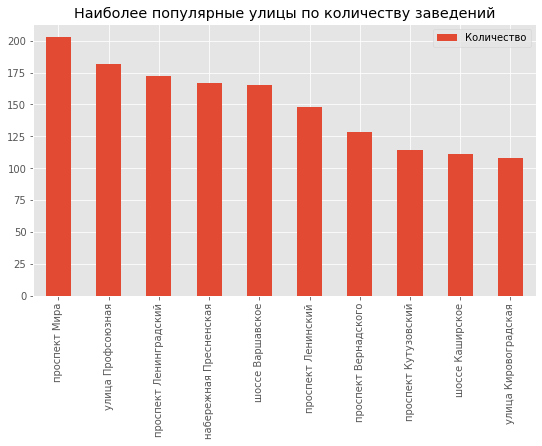

In [29]:
# с помощью ранее заданной функции построим график
bar_maker(data_dist.groupby('street').agg({'object_name': 'count'}).rename(columns={'object_name':'Количество'})\
                .sort_values(by = 'Количество', ascending = False).head(10),\
          'Наиболее популярные улицы по количеству заведений', '', '')

На популярных улицах более 100 заведений, на самой популярной — проспекте Мира — более 200 заведений. Посмотрим, есть ли предпочтения у рестораторов относительно районов.

In [30]:
# создадим таблицу с заведениями на популярных улицах
street_dist = data_dist.groupby('street').agg({'object_name': 'count'}).reset_index()\
                        .sort_values(by = 'object_name', ascending = False).head(10)
street_list = list(set(street_dist['street']))
popular_streets = data_dist.query('street in @street_list')

# посмотрим, в каких районах больше всего заведений
popular_streets.groupby('area')['object_name'].count().reset_index().sort_values(by = 'object_name', ascending = False)\
                .rename(columns={'object_name':'quantity'})

,area,quantity
2,Донской район,313
1,Алексеевский район,203
0,Академический район,182
5,Район Аэропорт,172
4,Пресненский район,167
3,Ломоносовский район,128
6,Район Дорогомилово,114
7,Район Москворечье-Сабурово,111
8,Район Чертаново Северное,108


Почти все улицы относятся к разным районам. Популярные районы находятся в разных частях Москвы, ни один не попадает в непосредственный центр — вероятно, высокие арендные ставки являются препятствием для развития заведений общепита, поэтому кафе и рестораны открывают рядом: Пресненский район и Дорогомилово находятся в непосредственной близости от Арбата. Изучим, заведение каких форматов и с какой вместительностью размещаются на этих улицах.

In [31]:
# посчитаем количество заведений по типам
popular_types = popular_streets.groupby('object_type')['object_name'].count().reset_index()\
                .sort_values(by = 'object_name', ascending = False)\
                .rename(columns = {'object_name':'quantity'})

# найдем общее количество заведений в таблице
total = popular_types.sum(axis = 0)

# добавим столбец с долей каждого типа в общем количестве
popular_types['part'] = popular_types.apply(lambda x: '{:.2f}%'.format(x['quantity'] / total['quantity'] * 100), axis=1)
popular_types

,object_type,quantity,part
3,кафе,633,42.26%
6,ресторан,290,19.36%
8,фастфуд,253,16.89%
7,столовая,139,9.28%
0,бар,63,4.21%
4,кафетерий,48,3.20%
1,буфет,32,2.14%
5,кулинария,24,1.60%
2,закусочная,16,1.07%


Самый популярный формат — кафе (42%), их количество в 2 раза превышает рестораны, расположившиеся на второй строчке. Количество заведений фастфуда практически совпадает с ресторанами. Бары, кафетерии, буфеты, кулинарии и закусочные вместе составляют чуть более 20% от количества заведений. Посмотрим, чаще встречаются вместительные заведения или компактные.

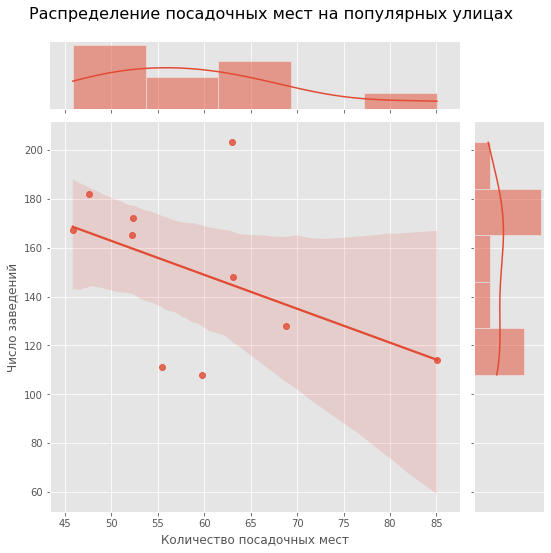

In [32]:
# подготовим датасет
street_scatter = popular_streets.groupby('street').agg({'street':'count', 'number':'mean'})

# построим график
with plt.style.context('ggplot'):
    s = sns.jointplot(x='number', y='street', data=street_scatter, kind='reg')
    s.fig.set_figwidth(8)
    s.fig.set_figheight(8)
    s.fig.suptitle('Распределение посадочных мест на популярных улицах', fontsize=16)
    s.fig.subplots_adjust(top = 0.92)
    s.set_axis_labels('Количество посадочных мест', 'Число заведений')

На 10 самых популярных улицах чаще встречается большое количество заведений с вместительнотстью до 65 человек. Распространены заведения с вместимостью от 55 до 70 человек.

In [33]:
# выведем данные о типах заведений и среднем количестве посадочных мест
# подготовим сводную таблицу
popular_pivot = popular_streets.pivot_table(index = 'street', columns = 'object_type', values = 'number', aggfunc = 'mean')\
                .fillna(0).astype('int').reset_index()

# добавим в таблицу информацию о количестве заведений, отсортируем по убыванию
streets_order = popular_streets.groupby('street').agg({'object_name': 'count'})
streets_objects = popular_pivot.merge(streets_order, how = 'left', on = 'street').sort_values(by = 'object_name', ascending = False)\
                .rename(columns={'object_name':'кол-во заведений'})
streets_objects.loc['среднее'] = streets_objects.mean(numeric_only=True)
streets_objects

,street,бар,буфет,закусочная,кафе,кафетерий,кулинария,ресторан,столовая,фастфуд,кол-во заведений
5,проспект Мира,60.0,30.0,30.0,59.0,4.0,4.0,113.0,99.0,44.0,203.0
7,улица Профсоюзная,34.0,46.0,1.0,40.0,5.0,12.0,67.0,146.0,13.0,182.0
3,проспект Ленинградский,50.0,32.0,0.0,36.0,13.0,14.0,85.0,83.0,24.0,172.0
0,набережная Пресненская,44.0,237.0,0.0,35.0,6.0,0.0,91.0,0.0,3.0,167.0
8,шоссе Варшавское,36.0,8.0,3.0,40.0,13.0,1.0,151.0,127.0,24.0,165.0
4,проспект Ленинский,24.0,133.0,4.0,38.0,8.0,0.0,105.0,90.0,22.0,148.0
1,проспект Вернадского,17.0,44.0,30.0,40.0,17.0,6.0,105.0,239.0,35.0,128.0
2,проспект Кутузовский,323.0,15.0,0.0,30.0,0.0,5.0,116.0,118.0,25.0,114.0
9,шоссе Каширское,22.0,34.0,0.0,40.0,11.0,0.0,119.0,152.0,24.0,111.0
6,улица Кировоградская,63.0,24.0,29.0,42.0,5.0,7.0,87.0,222.0,14.0,108.0


На популярных улицах расположены:
- довольно вместительные рестораны (в среднем 103 посадочных места) и столовые (127 мест);
- небольшие кафе и фастфуды (40 и 22 посадочных места соответственно);
- среднего размера бары и буфеты (67 и 60 мест соответственно).

На Кутузовском проспекте, как оказалось, расположены весьма вместительные бары (среднее число мест 323). А на Пресненской набережной очень компактые фастфуды (3 места) и ни одной кулинарии, закусочной или столовой. На 4 из 10 рассматриваемых улиц нет закусочных, еще на трех нет кулинарий. Итого на популярных улицах стремятся открыть формат slow-food и, вероятно, заведения с развлекательной программой. Изучим, в каких районах находятся самые непопулярные улицы.

In [34]:
# отберем улицы с одним заведением
one_object = data_dist.groupby('street')['object_name'].count().reset_index().query('object_name == 1')

# подготовим список улиц и в соответствии со списком отберем значения из таблицы
one_object_list = list(set(one_object['street']))
not_popular_streets = data_dist.query('street in @one_object_list')

# посмотрим, в каких районах расположены улицы с одним заведением
not_popular_streets_bar = not_popular_streets.groupby('area')['object_name'].count().reset_index().sort_values(by = 'object_name', ascending = False)\
                .rename(columns={'object_name':'quantity'}).head(10)
not_popular_streets_bar

,area,quantity
3,Басманный район,25
93,Таганский район,25
80,Район Хамовники,22
21,Пресненский район,20
94,Тверской район,19
13,Мещанский район,15
22,Район Арбат,14
51,Район Марьина роща,13
34,Район Замоскворечье,12
8,Даниловский район,11


99 улиц имеют всего одно заведение. Причем все районы из ТОП-10 находятся в центре Москвы, ТОП-5 практически самый центр: Басманный, Таганский, Хамовники, Пресненский, Тверской. Посмотрим, каково среднее количество посадочных мест на этих улицах.

**Вывод по разделу "Анализ заведений по улицам и районам":** улицы из ТОП-10 с самым большим числом заведений расположены в 9 районах Москвы, самые близкие к центру районы Пресненский (167 заведений) и Дорогомилово (114 заведений). Непосредственно в центре не так много заведений общепита: ТОП-5 улиц с одним заведением занимают районы из центра (Басманный, Таганский, Хамовники, Пресненский, Тверской). Причина такого положения дел может быть просто в длине центральных улиц — в исторической части много маленьких улиц, либо в арендной ставке, которая не соответствует отраслевой рентабельности.

Наиболее популярными являются форматы кафе (42%) и ресторанов (19,3%). Среднее количество посадочных мест на популярных улицах колеблется от 45 до 85, для кафе средний показатель составляет 40 посадочных мест (рестораны открывают в среднем на 100 посадочных мест). Закусочные и кафетерии непопулярны (менее 5% в сумме) и компатные (около 9 посадочных мест). Фастфуды распространены значительно (доля 17%), но небольшие (20 посадочных мест, среднее для сетевых заведений этого формата — 40 посадочных мест).

## <a>Общий вывод</a>

Выбранная концепция — кафе с официантами-роботами — должна способствовать начальному трафику посетителей. В связи с чем критичная транспортная доступность точки. Мы рекомендуем обратить внимание на центральные районы Москвы (Пресненский, Дорогомилово, Хамовники, Якиманка, Таганский, Басманный, Тверской), которые изначально являются центром притяжения горожан и гостей города. Выбор конкретной точки должен быть основан на совпадении совокупности факторов:
- красная линия, первый этаж, просматриваемый с улицы фасад;
- удобство подъезда и парковки (по возможности не выбирать односторонние улицы или улицы с разделительной полосой);
- потенциальный пешеходный трафик;
- арендная ставка.

С точки зрения выбора улицы рекомендовано обратить внимание на улицы со средним количеством заведений и улицы с репутацией "развлекательных": "кластеры" увеличивают общую посещаемость места, значит, выручку каждого заведения (в одно единственное кафе на конкретной улице надо ехать специально, посетители с большей вероятностью выберут для поездки место, где есть альтернативы — на случай, если не будет свободного столика или что-то еще пойдет не по плану).

Выбор количества мест зависит от расчетного объема инвестиций, допустимой длительности окупаемости проекта, доступных площадок в центре. Средний размер кафе — 40 посадочных мест, представляется возможным ориентироваться на него.

При масштабировании проекта рекомендуется придерживаться аналогичных рекомендаций: выбирать места с хорошим трафиком и соответствующей репутацией в центральных районах города, открывать формат кафе со средним числом посадочных мест.

## <a>Презентация</a>

https://drive.google.com/file/d/1l_ySZYrv5ITJxq4OziRvWU1jhOE67p2x/view?usp=sharing